# First Stupid Chatbot

Install the required libraries

In [ ]:
!pip install transformers sentence-transformers faiss-cpu langchain datasets

Import required libraries

In [ ]:
from sentence_transformers import SentenceTransformer
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModelForQuestionAnswering
from langchain.agents import AgentExecutor, Tool
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from datasets import load_dataset
import faiss
import numpy as np

In [ ]:
import os

os.environ['HF_TOKEN'] = "xxx"

Load RecipeNLG Dataset

In [ ]:
dataset = load_dataset("corbt/all-recipes", split="train[:10%]", trust_remote_code=True)

In [ ]:
print(dataset[0])

{'input': 'No-Bake Nut Cookies\n\nIngredients:\n- 1 c. firmly packed brown sugar\n- 1/2 c. evaporated milk\n- 1/2 tsp. vanilla\n- 1/2 c. broken nuts (pecans)\n- 2 Tbsp. butter or margarine\n- 3 1/2 c. bite size shredded rice biscuits\n\nDirections:\n- In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.\n- Stir over medium heat until mixture bubbles all over top.\n- Boil and stir 5 minutes more. Take off heat.\n- Stir in vanilla and cereal; mix well.\n- Using 2 teaspoons, drop and shape into 30 clusters on wax paper.\n- Let stand until firm, about 30 minutes.'}


In [ ]:
recipes = []

for item in dataset:
    recipe = item["input"]
    # Split the input into sections: title, ingredients, and directions
    parts = recipe.split("\n\n")
    if len(parts) >= 3:
        title = parts[0]  # First part is the title
        ingredients = parts[1].replace("Ingredients:\n", "").strip()  # Second part is ingredients
        directions = parts[2].replace("Directions:\n", "").strip()  # Third part is directions
        recipes.append(f"{title} - {ingredients} - {directions}")

print(f"Processed {len(recipes)} recipes successfully!")

Processed 214725 recipes successfully!


Set Up FAISS Vector Store

In [ ]:
import torch
from sentence_transformers import SentenceTransformer

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the SentenceTransformer model
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embedder = embedder.to(device)  # Move the model to GPU

# Encode recipes using the GPU
recipe_embeddings = embedder.encode(
  recipes,
  device=device,  # Specify GPU usage
  convert_to_tensor=True  # Returns embeddings as PyTorch tensors
)

In [ ]:
recipe_embeddings = recipe_embeddings.cpu().numpy()
dimension = recipe_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(np.array(recipe_embeddings))

Load HuggingFace Models

In [ ]:
qa_model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")
qa_tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

Device set to use cpu


Memory for Personalized Recommendations

In [ ]:
memory = ConversationBufferMemory()

Helper Functions

In [ ]:
def retrieve_recipe(query):
    query_embedding = embedder.encode([query])
    distances, indices = faiss_index.search(query_embedding, k=5)
    return [recipes[i] for i in indices[0]]

def summarize_recipe(recipe):
    return summarizer(recipe, max_length=50, min_length=10, do_sample=False)[0]['summary_text']

def clarify_query(context, question):
    inputs = qa_tokenizer(question, context, return_tensors="pt")
    outputs = qa_model(**inputs)
    answer_start = outputs.start_logits.argmax()
    answer_end = outputs.end_logits.argmax()
    return qa_tokenizer.decode(inputs["input_ids"][0][answer_start:answer_end+1])

def generate_response(prompt):
    inputs = gpt2_tokenizer.encode(prompt, return_tensors="pt")
    outputs = gpt2_model.generate(inputs, max_length=100, num_return_sequences=1)
    return gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)

Agent Implementation

In [ ]:
def chatbot(query):
    # Retrieve recipes
    retrieved_recipes = retrieve_recipe(query)
    if not retrieved_recipes:
        return {"error": "No recipes found for your query."}

    # Summarize first recipe
    summarized_recipe = summarize_recipe(retrieved_recipes[0])

    # Save user query and system response in memory
    memory.save_context(
        {"user_input": query},  # Input context
        {"system_output": summarized_recipe}  # Output context
    )

    # Generate personalized response
    personalized_response = generate_response(f"The user asked: {query}\nResponse:")

    return {
        "retrieved_recipes": retrieved_recipes,
        "summarized_recipe": summarized_recipe,
        "personalized_response": personalized_response,
    }


Interaction Loop (for Testing)

In [ ]:
print("Recipe Recommendation Chatbot Initialized! Type your queries below.")
while True:
    user_query = input("\nYou: ")
    if user_query.lower() in ["exit", "quit"]:
        print("Goodbye!")
        break
    print(f"This is the query {user_query}")
    response = chatbot(user_query)
    print("\nRetrieved Recipes:")
    for i, recipe in enumerate(response["retrieved_recipes"]):
        print(f"{i+1}. {recipe}")
    print("\nSummarized Recipe:")
    print(response["summarized_recipe"])
    print("\nPersonalized Response:")
    print(response["personalized_response"])

# Second Dumb Chatbot

In [ ]:
!pip install transformers datasets faiss-cpu sentence-transformers langchain langchain_community

In [ ]:
import torch
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import faiss
import numpy as np
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.agents import Tool, AgentExecutor, initialize_agent, AgentType
from langchain.tools import tool
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.schema import Document
import json

In [ ]:
# Load Sentence Transformer for retrieval
retrieval_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Load GPT-2 for generation
generation_model = GPT2LMHeadModel.from_pretrained('gpt2')
generation_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Load Question Answering model for clarifying user queries
qa_model = pipeline('question-answering', model='deepset/roberta-base-squad2')

# Load Summarization model for recipe summaries
summarization_model = pipeline('summarization', model='facebook/bart-large-cnn')

# Load all-recipes dataset
recipes = load_dataset("corbt/all-recipes", split="train[:10%]", trust_remote_code=True)

In [ ]:
recipe_texts = []

for item in recipes:
    recipe = item["input"]
    # Split the input into sections: title, ingredients, and directions
    parts = recipe.split("\n\n")
    if len(parts) >= 3:
        title = parts[0]  # First part is the title
        ingredients = parts[1].replace("Ingredients:\n", "").strip()  # Second part is ingredients
        directions = parts[2].replace("Directions:\n", "").strip()  # Third part is directions
        recipe_texts.append(f"{title} - {ingredients} - {directions}")

print(f"Processed {len(recipe_texts)} recipes successfully!")

Processed 214725 recipes successfully!


In [ ]:
if False:
    # Check if GPU is available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    retrieval_model = retrieval_model.to(device)  # Move the model to GPU

    # Encode recipes using the GPU
    recipe_embeddings = retrieval_model.encode(
      recipe_texts,
      device=device,  # Specify GPU usage
      convert_to_tensor=True  # Returns embeddings as PyTorch tensors
    )

    recipe_embeddings = recipe_embeddings.cpu().numpy()

    # Move models to the correct device
    generation_model.to(device)
    qa_model.model.to(device)
    summarization_model.model.to(device)

else:
    # Load embeddings from the file
    recipe_embeddings = np.load("recipe_embeddings.npy")
    print("Embeddings loaded successfully!")


Embeddings loaded successfully!


In [ ]:
# Build FAISS index
dimension = recipe_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(recipe_embeddings))

In [ ]:
# Tool for retrieving recipes
@tool
def retrieve_recipes(query: str) -> str:
    """Retrieve recipes based on user query."""
    query_embedding = retrieval_model.encode([query])
    distances, indices = index.search(np.array(query_embedding), k=5)
    retrieved_recipes = [recipe_texts[i] for i in indices[0]]
    return "\n\n".join([f"Title: {r['title']}\nInstructions: {r['instructions']}" for r in retrieved_recipes])

# Tool for summarizing recipes
@tool
def summarize_recipe(recipe_text: str) -> str:
    """Summarize a recipe."""
    summary = summarization_model(recipe_text, max_length=50, min_length=25, do_sample=False)
    return summary[0]['summary_text']

# Tool for clarifying user queries
@tool
def clarify_query(query: str) -> str:
    """Clarify user queries using a QA model. Always use this tool to clarify user queries."""
    clarification = qa_model(question="What are you looking for?", context=query)
    return clarification['answer']

# Tool for storing user preferences
user_memory = {}

@tool
def store_preferences(input_data: str) -> str:
    """Store user preferences and feedback."""
    # Parse the input data
    try:
        data = json.loads(input_data)
        user_id = data.get("user_id")
        preference = data.get("preference")
        if not user_id or not preference:
            return "Error: Both 'user_id' and 'preference' must be provided."
    except json.JSONDecodeError:
        return "Error: Input must be a valid JSON string with 'user_id' and 'preference'."

    # Store the preference
    if user_id not in user_memory:
        user_memory[user_id] = []
    user_memory[user_id].append(preference)
    return f"Preferences stored for user {user_id}."

# List of tools
tools = [retrieve_recipes, summarize_recipe, clarify_query, store_preferences]

In [ ]:
# Initialize GPT-2 as a LangChain LLM
generation_pipeline = pipeline(
    "text-generation",
    model=generation_model,
    tokenizer=generation_tokenizer,
    max_new_tokens=50,
    device=0 if torch.cuda.is_available() else -1
)
# Add this line to handle unknown tokens
# generation_pipeline.tokenizer.pad_token = generation_pipeline.tokenizer.eos_token
# generation_pipeline.model.config.pad_token_id = generation_pipeline.tokenizer.eos_token_id

llm = HuggingFacePipeline(pipeline=generation_pipeline)

# Initialize memory
memory = ConversationBufferMemory(memory_key="chat_history")

Device set to use cpu
<ipython-input-8-9b3a8a4d0348>:13: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=generation_pipeline)
<ipython-input-8-9b3a8a4d0348>:16: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history")


In [ ]:
# Define a custom prompt for the agent
prompt = PromptTemplate(
    input_variables=["input"],
    template="""
              You are a helpful recipe recommendation assistant. Your task is to clarify user queries and retrieve relevant recipes.

              If the user provides a query, always use the `clarify_query` tool to clarify the query before proceeding.

              User Query: {input}

              Clarified Query:
              """
)

# Initialize agent
agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, #"conversational-react-description",
    memory=memory,
    verbose=True,
    prompt=prompt,
    handle_parsing_errors=True
)

In [ ]:
def chatbot(query: str, user_id: str) -> str:
    # Clarify the query
    print(f'This is the query {query}')
    clarified_query = agent.run(f"Clarify the query: {query}")

    # Retrieve recipes
    # truncated_query = clarified_query[:512]  # Adjust 512 as needed
    print(f'This is the clarified query: {clarified_query}')
    retrieved_recipes = agent.run(f"Retrieve recipes for: {clarified_query}") # Truncate here

    # Summarize recipes
    # truncated_recipes = retrieved_recipes[:512] # Adjust 512 as needed
    print(f'This is the retrieved query: {retrieved_recipes}')
    summarized_recipes = agent.run(f"Summarize the following recipes: {retrieved_recipes}") #Truncate here

    # Generate response
    # truncated_summary = summarized_recipes[:512] # Adjust 512 as needed
    response = agent.run(f"Generate a response for the user: {summarized_recipes}") # Truncate here

    # Store user preferences
    preference_input = json.dumps({"user_id": user_id, "preference": clarified_query})
    agent.run(f"Store preferences with input: {preference_input}")

    return response

In [ ]:
query = "I want a pancake recipe with blueberries and honey"
clarified_query = agent.run(f"Clarify the query: {query}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Parsing LLM output produced both a final answer and a parse-able action:: Answer the following questions as best you can. You have access to the following tools:

retrieve_recipes(query: str) -> str - Retrieve recipes based on user query.
summarize_recipe(recipe_text: str) -> str - Summarize a recipe.
clarify_query(query: str) -> str - Clarify user queries using a QA model. Always use this tool to clarify user queries.
store_preferences(input_data: str) -> str - Store user preferences and feedback.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [retrieve_recipes, summarize_recipe, clarify_query, store_preferences]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Que

Token indices sequence length is longer than the specified maximum sequence length for this model (1423 > 1024). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Parsing LLM output produced both a final answer and a parse-able action:: Answer the following questions as best you can. You have access to the following tools:

retrieve_recipes(query: str) -> str - Retrieve recipes based on user query.
summarize_recipe(recipe_text: str) -> str - Summarize a recipe.
clarify_query(query: str) -> str - Clarify user queries using a QA model. Always use this tool to clarify user queries.
store_preferences(input_data: str) -> str - Store user preferences and feedback.

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [retrieve_recipes, summarize_recipe, clarify_query, store_preferences]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Que

IndexError: index out of range in self

In [ ]:
print(clarified_query)

[your response here]
```

Begin!

Previous conversation history:


New input: Clarify the query: I want a pancake recipe with blueberries and honey

Searching: Searching recipe information in the database

Searching: Searches recipe information

Results: Results of a search

Comments: Comments on the reply

Searching: Searches and finds the original recipe


In [ ]:
# Example usage
user_id = "user_123"
query = "I want a pancake recipe with blueberries and honey"
response = chatbot(query, user_id)
print(response)

In [ ]:
# import numpy as np

# # Save embeddings to a file
# np.save("recipe_embeddings.npy", recipe_embeddings)
# print("Embeddings saved to 'recipe_embeddings.npy'")

Changing the generation model

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from langchain.llms import HuggingFacePipeline

# Load Flan-T5 model
flan_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")
flan_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
flan_pipeline = pipeline(
    "text2text-generation",
    model=flan_model,
    tokenizer=flan_tokenizer,
    max_length=100,
    device=0 if torch.cuda.is_available() else -1
)
llm_2 = HuggingFacePipeline(pipeline=flan_pipeline)

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cpu


In [ ]:
memory_2 = ConversationBufferMemory(memory_key="chat_history")

prompt_template = PromptTemplate(
    input_variables=["input"],
    template="""
    You are a helpful recipe recommendation assistant. Use the following tools to help the user:

    Tools:
    - retrieve_recipes: Retrieve recipes based on user query.
    - summarize_recipe: Summarize a recipe.
    - clarify_query: Clarify user queries using a QA model.
    - store_preferences: Store user preferences and feedback.

    User Input: {input}

    Your Response:
    """
)

agent_3 = initialize_agent(
    tools,
    llm_2,
    agent="conversational-react-description",
    memory=memory_2,
    verbose=True,
    prompt=prompt_template,
    handle_parsing_errors=True
)

In [ ]:
query = "I want a pancake recipe"
clarified_query = agent_3.run({"input": f"Clarify the query: {query}"})



> Entering new AgentExecutor chain...
Could not parse LLM output: `[retrieve_recipes]`
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
Observation: Invalid or incomplete response
Thought:Could not parse LLM output: `What is the reason for the error?`
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
Observation: Invalid or incomplete response
Thought:Could not parse LLM output: `What is the reason for the error?`
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
Observation: Invalid or incomplete response
Thought:Could not parse LLM output: `Could not parse LLM output: [retrieve_recipes] For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE Observation: Invalid or incomplete response`
For troubleshooting, visit: https://python.langchain.com/docs/troublesh

KeyboardInterrupt: 

# Smart Chatbot

In [1]:
!pip install --upgrade --quiet  tiktoken scikit-learn gpt4all langchain langchain-community langchain-core langchain_nomic langgraph datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.4/412.4 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.8 MB/s eta 0

In [2]:
import os

os.environ["USER_AGENT"] = "myagent"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = "xxx"
os.environ["TAVILY_API_KEY"] = "xxx"
os.environ['HF_TOKEN'] = "xxx"

In [3]:
from datasets import load_dataset

# Load all-recipes dataset
recipes = load_dataset("corbt/all-recipes", split="train[:5%]", trust_remote_code=True)

recipe_texts = []

for item in recipes:
    recipe = item["input"]
    # Split the input into sections: title, ingredients, and directions
    parts = recipe.split("\n\n")
    if len(parts) >= 3:
        title = parts[0]  # First part is the title
        ingredients = parts[1].replace("Ingredients:\n", "").strip()  # Second part is ingredients
        directions = parts[2].replace("Directions:\n", "").strip()  # Third part is directions
        recipe_texts.append(f"{title} - {ingredients} - {directions}")

print(f"Processed {len(recipe_texts)} recipes successfully!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/451 [00:00<?, ?B/s]

(…)-00000-of-00004-237b1b1141fdcfa1.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

(…)-00001-of-00004-d46654ac93566129.parquet:   0%|          | 0.00/165M [00:00<?, ?B/s]

(…)-00002-of-00004-3b4f78b99eedadc2.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

(…)-00003-of-00004-2369b90eb0860a76.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2147248 [00:00<?, ? examples/s]

Processed 107362 recipes successfully!


In [4]:
import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.tools import tool
from langchain_community.vectorstores import SKLearnVectorStore
from sentence_transformers import SentenceTransformer
from langchain_nomic.embeddings import NomicEmbeddings
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

## Load embeddings from the file
# recipe_embeddings = np.load("recipe_embeddings.npy")
# print("Embeddings loaded successfully!")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [5]:
class SentenceTransformerEmbeddings:
    def __init__(self, model_name):
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, texts):
        """
        Embed a list of texts using the SentenceTransformer model.
        """
        return self.model.encode(texts, convert_to_tensor=False).tolist()

    def embed_query(self, query):
        """
        Embed a single query using the SentenceTransformer model.
        """
        return self.model.encode(query, convert_to_tensor=False).tolist()

In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
recipe_splits = text_splitter.create_documents(recipe_texts)  # or create_documents if recipe_texts is raw text

# Initialize the SentenceTransformer model for embeddings
embedding_model = SentenceTransformerEmbeddings("sentence-transformers/all-MiniLM-L6-v2")

# Create a vector store from the text chunks
vectorstore = SKLearnVectorStore.from_texts(
    texts=[doc.page_content for doc in recipe_splits],  # Extract text from documents
    embedding=embedding_model
)

# Create a retriever from the vector store
retriever = vectorstore.as_retriever(k=4)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

In [8]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from transformers import pipeline
from langchain.llms import HuggingFacePipeline

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks.

    Use the following documents to answer the question.

    If you don't know the answer, just say that you don't know.

    Use three sentences maximum and keep the answer concise:
    Question: {question}
    Documents: {documents}
    Answer:
    """,
    input_variables=["question", "documents"],
)

# llm = ChatOllama(
#     model="llama3.1",
#     temperature=0,
# )

llm_pipeline = pipeline(
    "text-generation",
    model=GPT2LMHeadModel.from_pretrained("gpt2"),
    tokenizer=GPT2Tokenizer.from_pretrained("gpt2"),
    max_new_tokens=100,
)

llm = HuggingFacePipeline(pipeline=llm_pipeline)

rag_chain = prompt | llm | StrOutputParser()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
<ipython-input-8-2a827de55aef>:33: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=llm_pipeline)


In [9]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from langchain.llms import HuggingFacePipeline

# Load Flan-T5 model
flan_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")
flan_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
flan_pipeline = pipeline(
    "text2text-generation",
    model=flan_model,
    tokenizer=flan_tokenizer,
    max_new_tokens=100,
)
llm_2 = HuggingFacePipeline(pipeline=flan_pipeline)

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cuda:0


In [16]:
from langchain_core.output_parsers import JsonOutputParser

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Determine a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    JSON format is as follows: {{"score": "yes/no"}}""",
    input_variables=["question", "document"],
)

def format_llm_output(text: str) -> str:
    """Formats the LLM output into a valid JSON string."""
    return '{"score": "' + text + '"}'



retrieval_grader = prompt | llm_2 | StrOutputParser() | format_llm_output | JsonOutputParser()

In [17]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from typing_extensions import List, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        texts: list of texts
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]

In [18]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, Texts, that contains retrieved texts
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    print(f"This is the question: {question}")
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"

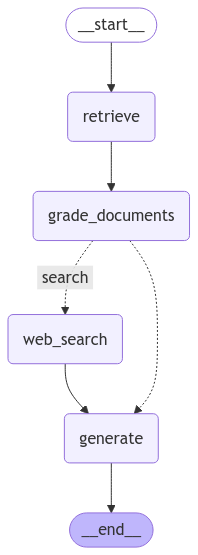

In [19]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"search": "web_search", "generate": "generate"},
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
import uuid

def predict_custom_agent_answer(example: dict):
    # This cell defines a function to predict the answer from a custom agent based on the provided example input.
    """
    Predicts the answer from a custom agent based on the provided example input.

    Args:
        example (dict): A dictionary containing the input question under the key "input".

    Returns:
        dict: A dictionary containing the response generated by the custom agent under the key "response",
              and the steps taken during the generation process under the key "steps".

    The `config` dictionary is used to pass configuration settings to the custom graph.
    In this case, it includes a unique `thread_id` generated using `uuid.uuid4()`.
    The `thread_id` ensures that each invocation of the function is uniquely identifiable,
    which can be useful for tracing and debugging purposes.
    """

    config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )

    return {"response": state_dict["generation"], "steps": state_dict["steps"]}

In [21]:
example = {
    "input": "How to bake a strawberry pie"
}

response = predict_custom_agent_answer(example)
response

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


This is the question: How to bake a strawberry pie


{'response': 'You are an assistant for question-answering tasks. \n    \n    Use the following documents to answer the question. \n    \n    If you don\'t know the answer, just say that you don\'t know. \n    \n    Use three sentences maximum and keep the answer concise:\n    Question: How to bake a strawberry pie \n    Documents: [Document(metadata={\'id\': \'1554061a-edc0-4b96-81c2-36cf8f8ada98\'}, page_content=\'Strawberry Pie - - 1 c. flour\\n- 1/3 c. oil\\n- 3 Tbsp. milk\\n- dash of salt - - Mix, pat out on pan and bake at 350° until brown.\'), Document(metadata={\'id\': \'37667bf4-bb96-4fbb-a2fb-b2007ff27c14\'}, page_content=\'Strawberry Pie - - 1 c. flour\\n- 2 Tbsp. confectioners sugar\\n- 1/2 c. butter or margarine - - Sift flour and sugar together; cut in butter until it looks like oatmeal.\\n- Chill 1 hour and then press into a 9-inch pie shell.\\n- Bake 10 minutes at 450°.\'), Document(metadata={\'id\': \'fd1452a5-f0c2-4798-a113-8809f87222ee\'}, page_content=\'Fresh Strawbe